# Marketing Attribution Model - Intarget Workshop

## Goal

- Build a data driven attribution model to to assign credits to Channels related to total conversions.
- Compare with the Last Click model.

## Hints & Constraints

- attribution_window=30

## Data Description

The data was provided by Intarget. The data is fictional, but the structure is consistent with previously conducted analyses at Intarget.

### Data Dictionary

| Column Name           | Description                                                                                    |
|-----------------------|------------------------------------------------------------------------------------------------|
| `fullvisitorId`       | Unique Visitor Identifier                                                                      |
| `date`                | Visit Date                                                                                     |
| `visitStartTime`      | Visit Timestamp (POSIX time)                                                                   |
| `channelGrouping`     | The Default Channel Group associated with a session                                            |
| `utm_source`          | Traffic Source (e.g: Facebook, Google, etc.)                                                   |
| `utm_medium`          | Traffic Medium (e.g.: organic, cpc, etc.)                                                      |
| `transactionRevenue`  | Transaction Revenue                                                                            |
| `transactionId`       | Unique Transaction Identifier                                                                  |


## Data Preprocessing

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing libraries used

import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [3]:
data = pd.read_csv("/Users/samaherbrahem/Documents/MSc DSE/Trimester 3/Intarget Lab/Project/marketing_attribution.csv")

In [4]:
# Handling missing values
data['transactionRevenue'].fillna(0, inplace=True)
data['transactionId'].fillna("", inplace=True)

# Converting visitStartTime to datetime
data['visitStartTime'] = pd.to_datetime(data['visitStartTime'], unit='s')

In [5]:
# Adding a conversion column to indicate whether there was a conversion or not
data['conversion'] = data['transactionRevenue'].apply(lambda x: True if pd.notna(x) and x > 0 else False)

In [6]:
data.head()

,fullVisitorId,date,visitId,visitStartTime,channelGrouping,utm_source,utm_medium,transactionRevenue,transactionId,conversion
0,9416183380303809617,2016-12-17,1481990278,2016-12-17 15:57:58,Organic Search,ask,organic,0.0,,False
1,342964634359205532,2016-12-17,1481999067,2016-12-17 18:24:27,Organic Search,ask,organic,0.0,,False
2,294887852901730140,2016-12-17,1481997033,2016-12-17 17:50:33,Organic Search,ask,organic,0.0,,False
3,2904105592463883270,2016-12-17,1482038661,2016-12-18 05:24:21,Display,dfa,cpm,0.0,,False
4,8140805711484568839,2016-12-17,1482030051,2016-12-18 03:00:51,Display,dfa,cpm,0.0,,False


## Exploratory Data Analysis

In [7]:
# Filtering conversions
conversions = data[data['conversion'] == True]

# Calculating total number of conversions and non conversions
total_conversions = data['conversion'].sum()
total_non_conversions = (~data['conversion']).sum()

# Calculating total number of visits
total_visits = len(data)

# Calculating conversion rate percentage
conversion_rate_percentage = (total_conversions / total_visits) * 100

print(f"Total number of conversions: {total_conversions}")
print(f"Total number of non-conversions: {total_non_conversions}")
print(f"Total number of visits: {total_visits}")
print(f"Total conversion rate: {conversion_rate_percentage:.2f}%")

Total number of conversions: 11515
Total number of non-conversions: 892138
Total number of visits: 903653
Total conversion rate: 1.27%


In [8]:
# Grouping data by channel grouping and count number of conversions for each channel
total_conversions_per_channel = data.groupby('channelGrouping')['conversion'].sum()

# Calculating total number of visits per channel
total_visits_per_channel = data.groupby('channelGrouping').size()

# Calculating conversion rate per channel
conversion_rate_per_channel = (total_conversions_per_channel / total_visits_per_channel) * 100

print("\nConversion rate per channel:")
print(conversion_rate_per_channel.sort_values(ascending=False))


Conversion rate per channel:
channelGrouping
Referral          5.065911
Display           2.267646
Paid Search       1.847903
Direct            1.427712
Organic Search    0.901035
(Other)           0.833333
Affiliates        0.054868
Social            0.045994
dtype: float64


The **Referral** channel has the highest conversion rate at 5.07%, indicating it is the most effective at turning visits into conversions. **Display** follows with a conversion rate of 2.27%, while **Paid Search** achieves 1.85%. The **Direct** channel has a conversion rate of 1.43%, and **Organic Search** stands at 0.90%. The **(Other)** category has a conversion rate of 0.83%, **Affiliates** have a rate of 0.05%, and Social has the lowest conversion rate at 0.05%.

In [9]:
# Calculating the contribution to the conversion rate of each channel
conversion_rate_contribution_percentage_per_channel = (total_conversions_per_channel / total_conversions) * 100

# Combining the results into a DataFrame
conv_summary = pd.DataFrame({
    'total_conversions': total_conversions_per_channel,
    'conversion_rate_contribution_percentage': conversion_rate_contribution_percentage_per_channel
}).reset_index()

# Sorting it in descending order
conv_summary = conv_summary.sort_values(by='conversion_rate_contribution_percentage', ascending=False)

conv_summary

,channelGrouping,total_conversions,conversion_rate_contribution_percentage
6,Referral,5311,46.122449
4,Organic Search,3438,29.856709
2,Direct,2042,17.733391
5,Paid Search,468,4.064264
3,Display,142,1.233174
7,Social,104,0.903170
1,Affiliates,9,0.078159
0,(Other),1,0.008684


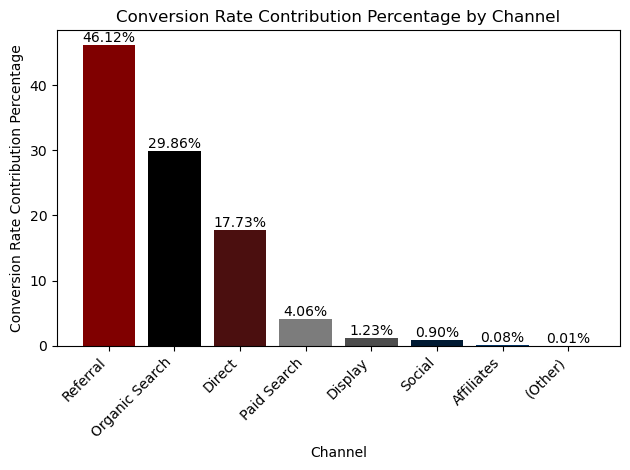

In [10]:
channel_colors = {
    'Direct': '#4b0f0f',
    'Organic Search': '#000000',
    'Display': '#4d4d4d',
    'Paid Search': '#7c7c7c',
    'Social': '#001a33',
    'Referral': '#800000',
    'Affiliates': '#003366',
    '(Other)': '#004080'
} 

# Plotting
plt.figure()
bars = plt.bar(conv_summary['channelGrouping'], conv_summary['conversion_rate_contribution_percentage'], 
               color=[channel_colors[channel] for channel in conv_summary['channelGrouping']])
plt.bar(conv_summary['channelGrouping'], conv_summary['conversion_rate_contribution_percentage'], color=[channel_colors[channel] for channel in conv_summary['channelGrouping']])
plt.xlabel('Channel')
plt.ylabel('Conversion Rate Contribution Percentage')
plt.title('Conversion Rate Contribution Percentage by Channel')
plt.xticks(rotation=45, ha='right') 
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')
plt.tight_layout()
plt.show()

The **Referral** channel contributes the most to the total conversions, accounting for 46.12% of all conversions. **Organic Search** is the second largest contributor with 29.86%, followed by **Direct** with 17.73%. **Paid Search** channels contribute 4.06% to the total conversions. The **Display** channel accounts for 1.23%, and **Social** contributes 0.90%. **Affiliates** have a minimal contribution of 0.08%, and the **(Other)** category has the smallest contribution at 0.01%.

In [11]:
# Defining the 30-day time window
time_window = timedelta(days=30)

# Sorting data by fullVisitorId and visitStartTime for efficient processing
data.sort_values(by=['fullVisitorId', 'visitStartTime'], inplace=True)

# Creating user journey for each user
user_journeys = []

for user, user_visits in data.groupby('fullVisitorId'):
    # Getting the latest conversion time if the user had any conversions, otherwise the latest visit time
    if user_visits['conversion'].any():
        conversion_time = user_visits[user_visits['conversion']]['visitStartTime'].max()
    else:
        conversion_time = user_visits['visitStartTime'].max()
    
    # Defining the window start time
    window_start = conversion_time - time_window
    
    # Filtering user visits within the 30-day window
    journey = user_visits[(user_visits['visitStartTime'] >= window_start) & 
                          (user_visits['visitStartTime'] <= conversion_time)]
    
    if not journey.empty:
        channels = journey['channelGrouping'].tolist()
        user_journey = {
            'fullVisitorId': user,
            'channels': channels,
            'conversion': journey['conversion'].any(),
            'number of touchpoints': len(channels)
        }
        user_journeys.append(user_journey)

# Converting user journeys to a DataFrame
user_journeys_df = pd.DataFrame(user_journeys)

In [12]:
user_journeys_df.head(10)

,fullVisitorId,channels,conversion,number of touchpoints
0,4823595352351,[Organic Search],False,1
1,5103959234087,[Organic Search],False,1
2,10278554503158,[Organic Search],False,1
3,20424342248747,[Organic Search],False,1
4,26722803385797,[Organic Search],False,1
5,27376579751715,[Organic Search],False,1
6,33471059618621,[Social],False,1
7,35794135966385,[Direct],False,1
8,39460501403861,[Social],False,1
9,40862739425590,"[Paid Search, Paid Search]",False,2


## Last-Click Attribution Model

### What It Is:

Last-click attribution is the attribution model that measures which marketing touchpoint a customer last clicked on or engaged with before purchasing, and gives it 100% of the credit.

In [13]:
conv_summary

,channelGrouping,total_conversions,conversion_rate_contribution_percentage
6,Referral,5311,46.122449
4,Organic Search,3438,29.856709
2,Direct,2042,17.733391
5,Paid Search,468,4.064264
3,Display,142,1.233174
7,Social,104,0.903170
1,Affiliates,9,0.078159
0,(Other),1,0.008684


## Shapley Value Model

### What It Is:

The Shapley Value is a method from cooperative game theory used to fairly distribute the total gain (or payoff) among players based on their contributions.

In marketing attribution, the "players" are different marketing channels or touchpoints that a user interacts with before converting.

### How It Works:

1. Identify All Touchpoints: List all the interactions (e.g., ads, emails) a user has before converting.
2. Calculate Marginal Contribution: Determine how much each touchpoint contributes to the conversion by considering all possible combinations of touchpoints.
    - For example, what is the conversion rate if we include or exclude a particular touchpoint?
3. Average Contributions: Calculate the average contribution of each touchpoint across all combinations.
4. Distribute Credit: Assign conversion credit to each touchpoint based on their average contribution.

In [14]:
# Function to calculate Shapley Value for each channel
def calculate_shapley(df):
    channels = set(itertools.chain.from_iterable(df['channels']))
    shapley_values = {channel: 0 for channel in channels}
    
    # Count total number of conversions
    total_conversions = df['conversion'].sum()
    
    for _, row in df.iterrows():
        if row['conversion']:
            n = len(row['channels'])
            for channel in row['channels']:
                # Each channel's marginal contribution is 1/n
                marginal_contribution = 1 / n
                shapley_values[channel] += marginal_contribution
    
    # Normalizing Shapley Values and converting to percentages
    for channel in shapley_values:
        shapley_values[channel] = (shapley_values[channel] / total_conversions) * 100
    
    return shapley_values

# Calculating Shapley Values
shapley_values = calculate_shapley(user_journeys_df)

# Sorting Shapley Values in descending order
sorted_shapley_values = sorted(shapley_values.items(), key=lambda x: x[1], reverse=True)

# Printing sorted Shapley Values
print("Shapley Values:")
for channel, value in sorted_shapley_values:
    print(f"{channel}: {value:.2f}")

Shapley Values:
Referral: 43.88
Organic Search: 31.06
Direct: 18.40
Paid Search: 4.46
Display: 1.22
Social: 0.88
Affiliates: 0.10
(Other): 0.01


The attribution analysis reveals the relative contributions of various marketing channels to total conversions. **Referral** traffic emerges as the most impactful, driving approximately 43.88% of conversions, followed by **organic search** at 31.06%. **Direct** traffic also plays a significant role, contributing 18.40% to total conversions. **Paid search** and **display** advertising make smaller contributions, accounting for around 4.46% and 1.22% of conversions respectively. **Social** media has a minor impact, contributing approximately 0.88%. **Affiliate** marketing plays a very small role, accounting for about 0.10% of conversions.

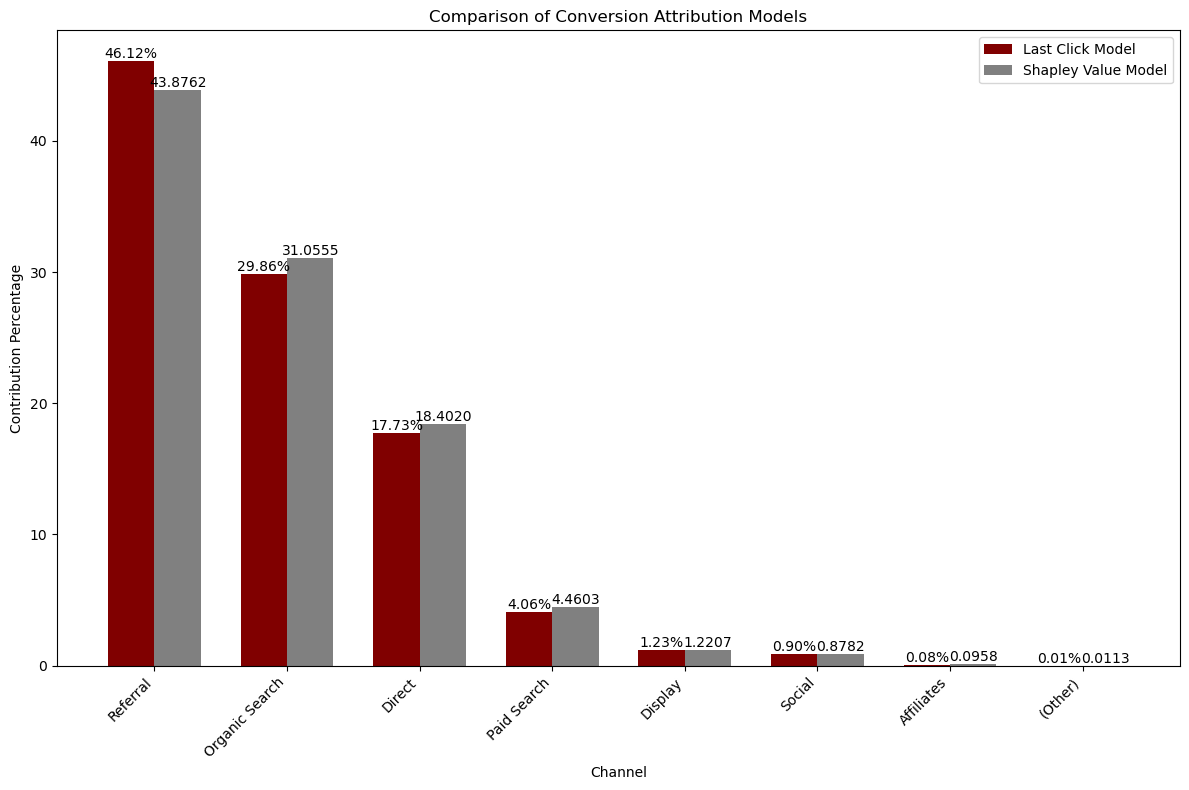

In [15]:
# Preparing Shapley Values for plotting
shapley_values_df = pd.DataFrame(sorted_shapley_values, columns=['channelGrouping', 'shapley_value'])

# Merge Shapley values with last-click model values
comparison_df = pd.merge(conv_summary, shapley_values_df, on='channelGrouping', how='outer').fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(comparison_df['channelGrouping']))

bars1 = ax.bar(index, comparison_df['conversion_rate_contribution_percentage'], bar_width, 
               label='Last Click Model', color='#800000')
bars2 = ax.bar(index + bar_width, comparison_df['shapley_value'], bar_width, 
               label='Shapley Value Model', color='gray')

ax.set_xlabel('Channel')
ax.set_ylabel('Contribution Percentage')
ax.set_title('Comparison of Conversion Attribution Models')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(comparison_df['channelGrouping'], rotation=45, ha='right')
ax.legend()

# Adding percentage labels on the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
